In [14]:
import datetime
# Get the current date and time
now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M")

## Load data

Change the column name at line 9 to one of the columns in the dataset to set the forcasting target.

In [15]:
import pandas as pd

# Load your sequential data of electricity demand
# Assuming your data is in a CSV file, with 'demand' column representing the electricity demand
data = pd.read_csv("./data/NET.csv")

data['Target'] = data['Net Demand']


## Autocorrelation

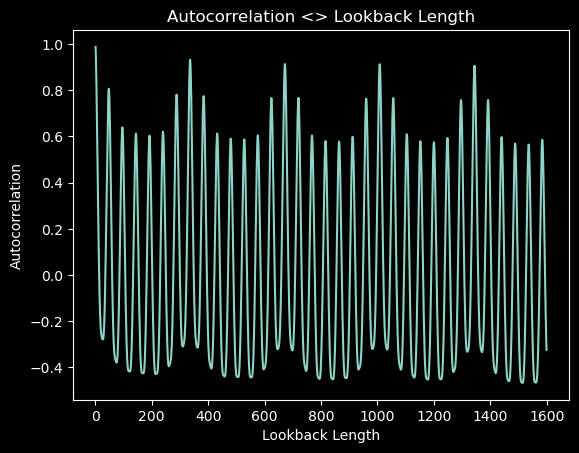

Best Lookback Length: 336


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate autocorrelation for different lookback lengths
lookback_lengths = range(1, 1600)
autocorrelation_values = []
for lookback in lookback_lengths:
  autocorrelation = data['Target'].autocorr(lag=lookback)
  autocorrelation_values.append(autocorrelation)

# Plot autocorrelation values
plt.plot(lookback_lengths, autocorrelation_values)
plt.xlabel('Lookback Length')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation <> Lookback Length')
plt.show()

# Sort the autocorrelation values in descending order
sorted_autocorrelation_values = sorted(autocorrelation_values, reverse=True)

best_lookback_length = max([lookback for lookback in lookback_lengths if lookback > 2], key=lambda x: autocorrelation_values[x-1])
print('Best Lookback Length:', best_lookback_length)


## Data transformation

In [27]:
from sklearn.preprocessing import RobustScaler
import joblib
import os

# Subtract the average from the data
target_avg = data['Target'].mean()
target_avg = 0 # Hardcoded average demand, 0 means no subtraction
print("Average demand: ", target_avg)
data['Target'] = data['Target'] - target_avg

# Normalize the data
scaler = RobustScaler()
data['Target'] = scaler.fit_transform(data['Target'].values.reshape(-1,1))


# Save the scaler
desDir = f'./model/{timestamp}'

if not os.path.exists(desDir):
    os.makedirs(desDir)
joblib.dump(scaler, f'./model/{timestamp}/robustScaler.pkl')

Average demand:  0


['./model/20240326_1030/robustScaler.pkl']

## Prepare data for training

In [18]:

# Function to create dataset with sequences of 48 demand values
def create_dataset(dataset, weeks=0, days=0, periods=48):
    look_back=periods + (days * 48) + (weeks * 7 * 48)
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

# Split data into training and testing sets
train_size = int(len(data) * 0.75)
validate_size = int(len(data) * 0.1)
test_size = len(data) - train_size - validate_size
train, validate, test = data.iloc[0:train_size], \
                        data.iloc[train_size:train_size+validate_size], \
                        data.iloc[train_size+validate_size:len(data)]

# Create datasets for training and testing
weeks = 1
days = 0
periods = 0
train_X, train_Y = create_dataset(train['Target'].values, weeks=weeks, days=days, periods=periods)
validate_X, validate_Y = create_dataset(validate['Target'].values, weeks=weeks, days=days, periods=periods)
test_X, test_Y = create_dataset(test['Target'].values, weeks=weeks, days=days, periods=periods)

print("Train X shape: ", train_X.shape)

Train X shape:  (9336, 336)


In [19]:
# Reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of train_X:", train_X.shape)
print("Shape of test_X: ", test_X.shape)


Shape of train_X: (9336, 336, 1)
Shape of test_X:  (1600, 336, 1)


## Bi-LSTM

In [20]:
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.keras.utils.disable_interactive_logging()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [21]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout
import keras.optimizers as optimizers

model = Sequential()
# First Bidirectional LSTM layer, returning sequences for the next LSTM layer
model.add(
    Bidirectional(
        LSTM(64, return_sequences=True), 
        input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(64)))
# Dense layer for output
model.add(Dense(1))

optimizer = optimizers.get("Adam")
optimizer.learning_rate = 0.0001

model.compile(optimizer=optimizer, loss='mse')
model.fit(train_X, train_Y, epochs=100, batch_size=32, verbose=0, validation_data=(validate_X, validate_Y))

loss        0.001231
val_loss    0.001569
Name: 99, dtype: float64


<Axes: >

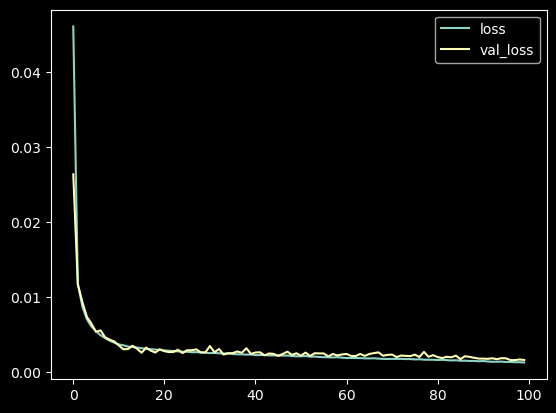

In [22]:
columns = [h for h in model.history.history.keys() if 'loss' in h]
loss_history = [ model.history.history[c] for c in columns ]
loss_history = pd.DataFrame(loss_history).T
loss_history.columns = columns
print(loss_history.iloc[-1])
loss_history.plot()

In [28]:
# Define the filename
filename = f'{desDir}/bi-lstm.keras'

# Save the model
model.save(filename)


## Predict & Evaluate

In [24]:
from sklearn.metrics import mean_squared_error

# Make predictions
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# Invert predictions to original scale
i_train_predict = scaler.inverse_transform(train_predict) + target_avg
i_train_Y = scaler.inverse_transform([train_Y]) + target_avg
i_test_predict = scaler.inverse_transform(test_predict) + target_avg
i_test_Y = scaler.inverse_transform([test_Y]) + target_avg


# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(i_train_Y[0], i_train_predict[:,0]))
test_score = np.sqrt(mean_squared_error(i_test_Y[0], i_test_predict[:,0]))

Train RMSE: 31.31586515126785


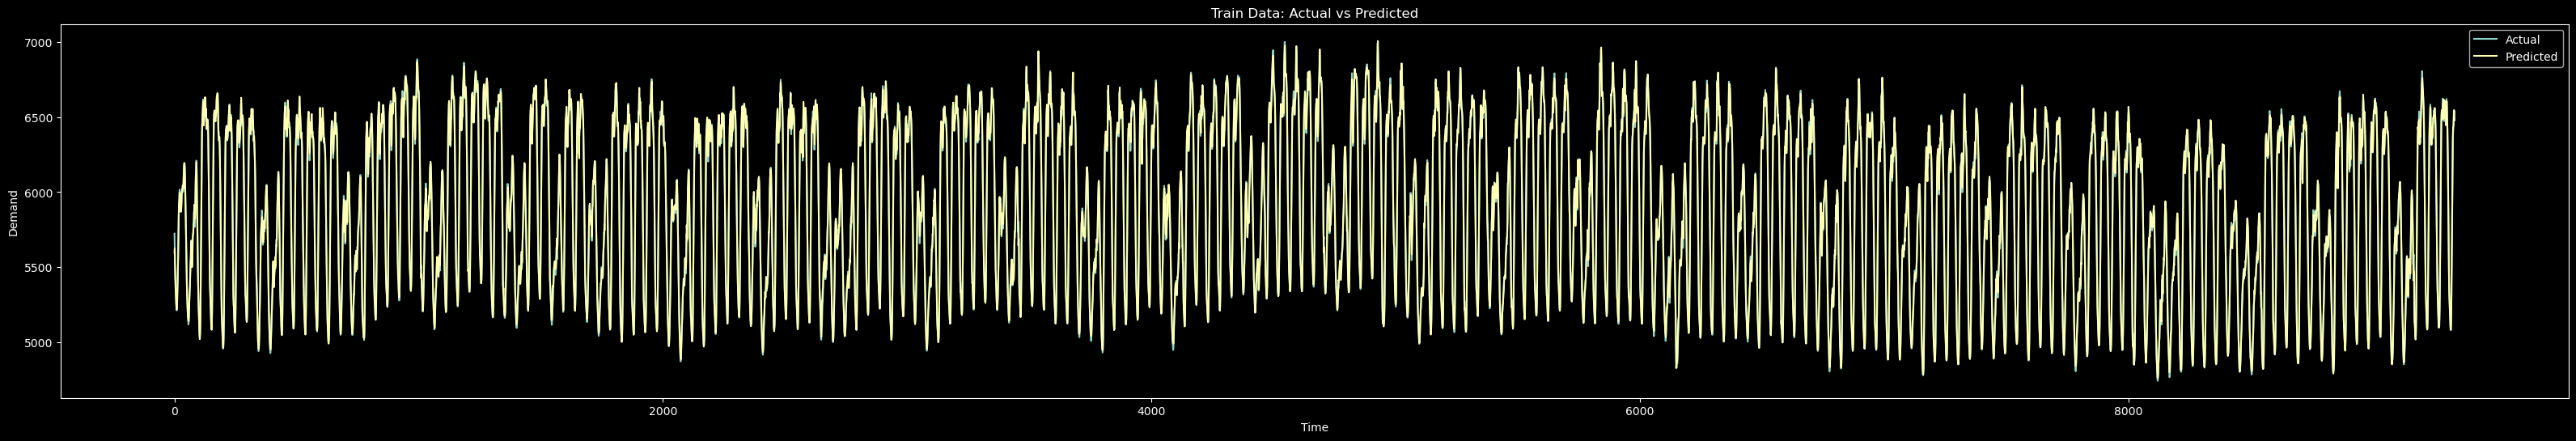

Test RMSE: 47.35094260792572


<Figure size 640x480 with 0 Axes>

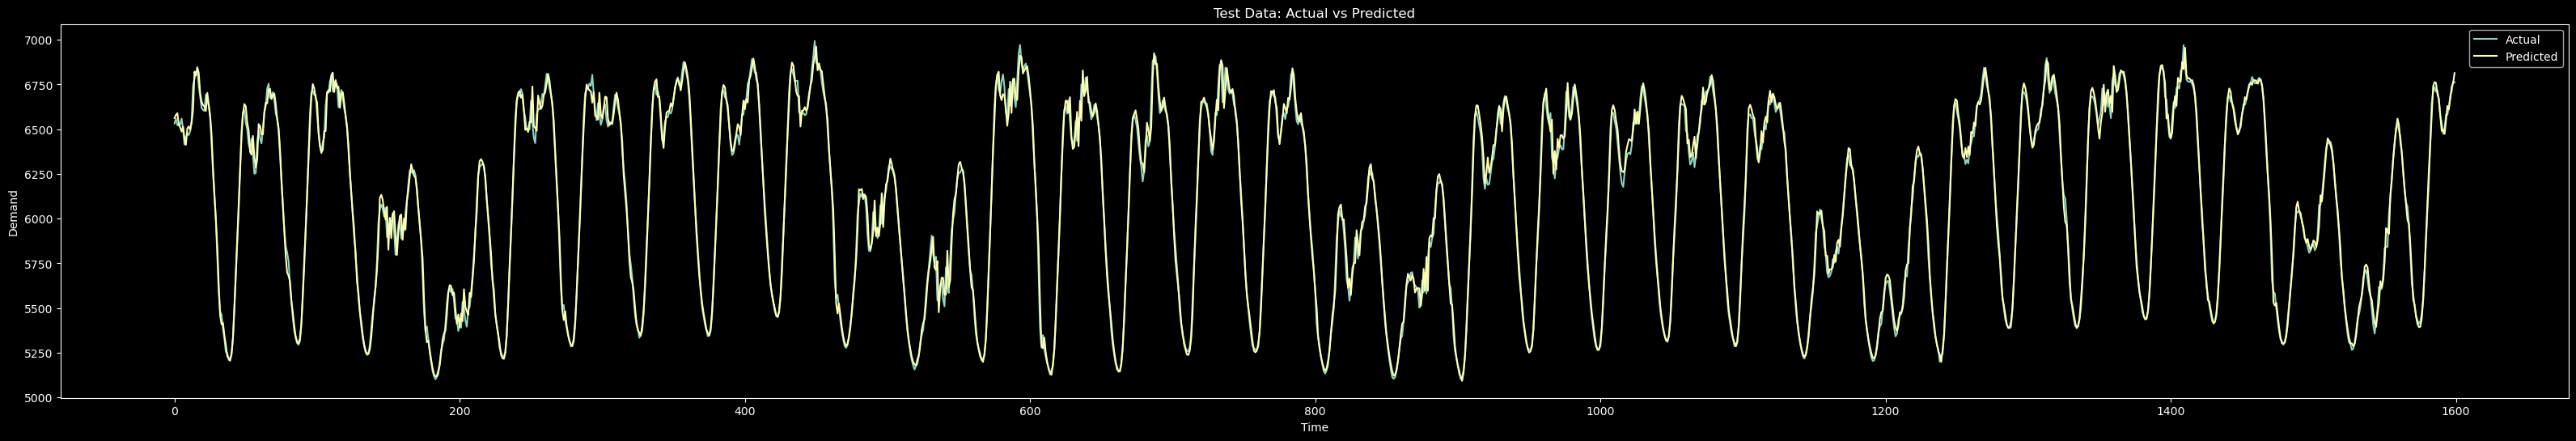

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt

print('Train RMSE:', train_score)

# Plot train data
plt.figure(figsize=(40, 6))
plt.plot(i_train_Y[0], label='Actual')
plt.plot(i_train_predict[:, 0], label='Predicted')
plt.title('Train Data: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()
plt.savefig(f'{desDir}/train.png')

print('Test RMSE:', test_score)

# Plot test data
plt.figure(figsize=(40, 6))
plt.plot(i_test_Y[0], label='Actual')
plt.plot(i_test_predict[:, 0], label='Predicted')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()
plt.savefig(f'{desDir}/test.png')


In [32]:
# Save a report of the model
report = {
    'timestamp': timestamp,
    'data': {
        'lookback': best_lookback_length,
        'weeks': weeks,
        'days': days,
        'periods': periods,
    },
    'RMSE': {
        'train': train_score,
        'test': test_score,
    }
}

import json

with open(f'{desDir}/report.json', 'w') as f:
    json.dump(report, f, indent=2)
    

In [26]:
# for i in range(50):
#     print(f"test_Y[{i:03d}]: {i_test_Y[0][i]:.12f}, test_predict[{i:03d}]: {i_test_predict[i][0]:.12f}, diff: {abs(i_test_predict[i][0] - i_test_Y[0][i]):.12f}")